# BLOCK 5: Clustering & Pattern Discovery (25 minutes)

## Clustering Fundamentals and Applications (5 minutes)

### What is Clustering?

**Clustering** is an unsupervised machine learning technique that groups similar data points together without prior knowledge of group labels. It discovers hidden patterns and structures in data by identifying natural groupings.

### Key Clustering Concepts:

1. **Similarity/Distance**: How we measure closeness between data points
2. **Centroids**: Representative points of clusters
3. **Intracluster Similarity**: Points within clusters are similar
4. **Intercluster Dissimilarity**: Points between clusters are different
5. **Cluster Validation**: Measuring clustering quality

### Clustering Applications in Oil Well Monitoring:

- **Operational States**: Identify distinct operational patterns
- **Sensor Grouping**: Find sensors that behave similarly
- **Fault Pattern Discovery**: Discover unknown fault signatures
- **Predictive Maintenance**: Group similar degradation patterns
- **Process Optimization**: Identify optimal operating conditions

### Our Clustering Analysis Approach:

**Data Strategy**: Using **raw 3W dataset** with 500-point time series
- **Raw Data Source**: Direct from 3W dataset folders (not windowed)
- **Fixed Length**: Resize each time series to exactly 500 points
- **Class Focus**: **Analyzing available fault classes** for focused comparison
- **Feature Matrix**: Each row = one 500-point time series per sensor

### Clustering Methods We'll Explore:

1. **K-means**: Centroid-based partitioning with elbow method & silhouette analysis
2. **Mean Shift**: Density-based clustering finding modes
3. **DBSCAN**: Density-based clustering with noise detection
4. **Evaluation**: Cluster quality metrics and interpretability

### Why Clustering Matters for 3W Dataset:
- **Pattern Discovery**: Find unknown operational patterns among selected fault types
- **Data Understanding**: Reveal natural groupings in sensor data
- **Dimensionality Analysis**: Understand sensor relationships
- **Fault Discrimination**: Distinguish between different fault types in the dataset
- **Process Knowledge**: Gain understanding of specific oil well failure modes

In [1]:
# ============================================================
# IMPORT LIBRARIES AND SETUP
# ============================================================

print("Setting up Clustering Analysis Environment")
print("=" * 45)

# Import required libraries
import sys
import os
import time
import numpy as np

# Add src to path
sys.path.append("src")

print("Importing clustering utilities...", end=" ")
from src.clustering_utils import ClusteringDataLoader
from src.data_persistence import DataPersistence
from src import config
print("OK")

# Configuration
TARGET_LENGTH = 500  # Fixed length for all time series
MAX_FILES_PER_CLASS = 20  # Limit files per class for manageable analysis
ENABLE_SAMPLING = True  # Enable sampling for faster processing
TARGET_CLASSES = [3, 4, 8]  # Preferred classes to analyze (will adapt if not available)

print(f"\nClustering Configuration:")
print(f"   • Target time series length: {TARGET_LENGTH} points")
print(f"   • Max files per class: {MAX_FILES_PER_CLASS}")
print(f"   • Sampling enabled: {ENABLE_SAMPLING}")
print(f"   • Preferred classes for analysis: {TARGET_CLASSES}")

# Initialize data loader
data_loader = ClusteringDataLoader(
    target_length=TARGET_LENGTH,
    max_files_per_class=MAX_FILES_PER_CLASS,
    enable_sampling=ENABLE_SAMPLING
)

print("\nSetup complete! Ready to load data.")

Setting up Clustering Analysis Environment
Importing clustering utilities... Importing clustering utilities... OK

Clustering Configuration:
   • Target time series length: 500 points
   • Max files per class: 20
   • Sampling enabled: True
   • Preferred classes for analysis: [3, 4, 8]

Setup complete! Ready to load data.
OK

Clustering Configuration:
   • Target time series length: 500 points
   • Max files per class: 20
   • Sampling enabled: True
   • Preferred classes for analysis: [3, 4, 8]

Setup complete! Ready to load data.


In [2]:
# ============================================================
# LOAD RAW 3W DATASET
# ============================================================

start_time = time.time()

print("Loading Raw 3W Dataset for Clustering Analysis")
print("=" * 55)

try:
    # Initialize data persistence
    print("Initializing data persistence...", end=" ")
    persistence = DataPersistence(base_dir=config.PROCESSED_DATA_DIR, verbose=False)
    print("OK")

    # Access raw dataset directory
    raw_data_dir = os.path.join(persistence.cv_splits_dir, "raw")
    print(f"Raw data directory: {raw_data_dir}")

    if not os.path.exists(raw_data_dir):
        raise FileNotFoundError(f"Raw data directory not found: {raw_data_dir}")

    # Load data using the utility class
    load_start = time.time()
    raw_data_result = data_loader.load_raw_data(persistence, raw_data_dir)
    load_time = time.time() - load_start

    # Extract results
    X_original = raw_data_result['X_original']
    y_labels = raw_data_result['y_labels']
    file_info = raw_data_result['file_info']
    fold_used = raw_data_result['fold_used']
    
    # Check what classes are available in the dataset
    available_classes = sorted(np.unique(y_labels))
    print(f"\nAvailable classes in dataset: {available_classes}")
    
    # Convert classes to consistent format for comparison
    # Handle both string and numeric class labels
    if len(available_classes) > 0 and isinstance(available_classes[0], (np.str_, str)):
        # Classes are strings, convert target classes to strings for comparison
        target_classes = ['3', '4', '8']
        available_classes_for_comparison = [str(cls) for cls in available_classes]
    else:
        # Classes are numeric
        target_classes = [3, 4, 8]
        available_classes_for_comparison = available_classes
    
    # Filter to analyze only classes 3, 4, and 8 (if they exist)
    existing_target_classes = [cls for cls in target_classes if cls in available_classes_for_comparison]
    
    if len(existing_target_classes) == 0:
        print(f"WARNING: None of the target classes {target_classes} exist in the dataset.")
        print(f"Available classes: {available_classes}")
        # Use the first 3 available classes instead
        if len(available_classes) >= 3:
            existing_target_classes = available_classes_for_comparison[:3]
            print(f"Using first 3 available classes instead: {existing_target_classes}")
        else:
            existing_target_classes = available_classes_for_comparison
            print(f"Using all available classes: {existing_target_classes}")
    
    print(f"\nFiltering data to analyze classes: {existing_target_classes}")
    
    # Create mask for target classes (convert back to original format for filtering)
    if isinstance(available_classes[0], (np.str_, str)):
        # For string classes, we need to filter using the original string format
        target_classes_for_filtering = existing_target_classes
    else:
        # For numeric classes, convert string targets back to numeric if needed
        target_classes_for_filtering = [int(cls) if isinstance(cls, str) else cls for cls in existing_target_classes]
    
    class_mask = np.isin(y_labels, target_classes_for_filtering)
    
    # Filter data
    X_original = X_original[class_mask]
    y_labels = y_labels[class_mask]
    file_info = [file_info[i] for i, mask in enumerate(class_mask) if mask]
    
    print(f"Filtered data summary:")
    print(f"   • Samples after filtering: {len(X_original)}")
    print(f"   • Classes included: {sorted(np.unique(y_labels))}")

    print(f"\nRaw Data Loading Complete!")
    print(f"Data Summary:")
    print(f"   • Total time series: {len(X_original)}")
    print(f"   • Feature dimensions: {X_original.shape[1]}")
    print(f"   • Time series length: {TARGET_LENGTH} points per sensor")
    print(f"   • Loading time: {load_time:.3f} seconds")
    print(f"   • Data source: {fold_used}")

    # Show class distribution
    unique_classes, counts = np.unique(y_labels, return_counts=True)
    print(f"\nClass Distribution:")
    for cls, count in zip(unique_classes, counts):
        percentage = (count / len(y_labels)) * 100
        print(f"   • Class {cls}: {count} samples ({percentage:.1f}%)")

    # Show feature statistics
    print(f"\nFeature Statistics:")
    print(f"   • Mean: {np.mean(X_original):.4f}")
    print(f"   • Std: {np.std(X_original):.4f}")
    print(f"   • Min: {np.min(X_original):.4f}")
    print(f"   • Max: {np.max(X_original):.4f}")

    # Store for next cells
    clustering_data = {
        'X_original': X_original,
        'y_labels': y_labels,
        'file_info': file_info,
        'config': {
            'target_length': TARGET_LENGTH,
            'max_files_per_class': MAX_FILES_PER_CLASS,
            'sampling_enabled': ENABLE_SAMPLING,
            'fold_used': fold_used
        }
    }

    total_time = time.time() - start_time
    print(f"\nTotal execution time: {total_time:.3f} seconds")

except Exception as e:
    print(f"ERROR: Error loading raw data: {str(e)}")
    print(f"\nTroubleshooting:")
    print(f"   1. Check if 3W dataset is properly extracted")
    print(f"   2. Verify raw data directory exists")
    print(f"   3. Ensure fold directories contain pickle/parquet files")
    
    import traceback
    traceback.print_exc()
    clustering_data = None

Loading Raw 3W Dataset for Clustering Analysis
Initializing data persistence... OK
Raw data directory: processed_data\cv_splits\raw
Loading Raw 3W Dataset for Clustering Analysis
Using fold_1 for clustering analysis

Loading train_data...

Loading test_data...

Loading test_data...

Available classes in dataset: [np.str_('0'), np.str_('1'), np.str_('2'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9')]

Filtering data to analyze classes: ['3', '4', '8']
Filtered data summary:
   • Samples after filtering: 103
   • Classes included: [np.str_('3'), np.str_('4'), np.str_('8')]

Raw Data Loading Complete!
Data Summary:
   • Total time series: 103
   • Feature dimensions: 1500
   • Time series length: 500 points per sensor
   • Loading time: 2.543 seconds
   • Data source: fold_1

Class Distribution:
   • Class 3: 20 samples (19.4%)
   • Class 4: 66 samples (64.1%)
   • Class 8: 17 samples (16.5%)

Feature Statistics:
   • Mean: 0.4178
   • S

In [3]:
# ============================================================
# DATA PREPROCESSING SETUP
# ============================================================

print("Data Preparation for Clustering Analysis")
print("=" * 45)

# Check if we have loaded data from previous cell
if "clustering_data" in locals() and clustering_data is not None:
    
    # Import preprocessing utilities
    from src.clustering_utils import ClusteringPreprocessor
    import warnings
    warnings.filterwarnings("ignore")

    # Extract raw data
    X_original = clustering_data["X_original"]
    y_labels = clustering_data["y_labels"]
    file_info = clustering_data["file_info"]

    print(f"Raw Data Overview:")
    print(f"   • Data shape: {X_original.shape}")
    print(f"   • Classes: {sorted(np.unique(y_labels))}")
    print(f"   • Total samples: {len(X_original)}")

    # Initialize preprocessor
    preprocessor = ClusteringPreprocessor()
    
    print("\nPreprocessor initialized. Ready for data preparation.")

else:
    print("No data available for preprocessing")
    print("   Please run the previous cells first to load raw 3W data")
    clustering_data = None

Data Preparation for Clustering Analysis
Raw Data Overview:
   • Data shape: (103, 1500)
   • Classes: [np.str_('3'), np.str_('4'), np.str_('8')]
   • Total samples: 103

Preprocessor initialized. Ready for data preparation.


In [4]:
# ============================================================
# APPLY DATA PREPROCESSING
# ============================================================

if "preprocessor" in locals() and preprocessor is not None:
    
    print("Applying data preprocessing transformations...")
    
    # Prepare data with scaling and dimensionality reduction
    processed_data = preprocessor.prepare_data(X_original)
    
    # Extract processed datasets
    X_scaled = processed_data['X_scaled']
    X_normalized = processed_data['X_normalized']
    X_pca_50 = processed_data['X_pca_50']
    X_pca_95 = processed_data['X_pca_95']
    X_pca_2d = processed_data['X_pca_2d']
    pca_model = processed_data['pca_model']
    variance_info = processed_data['variance_info']
    
    print(f"\nPreprocessed Data Summary:")
    print(f"   • Original: {X_original.shape}")
    print(f"   • StandardScaled: {X_scaled.shape}")
    print(f"   • MinMax Normalized: {X_normalized.shape}")
    print(f"   • PCA (50 components): {X_pca_50.shape}")
    print(f"   • PCA (95% variance): {X_pca_95.shape}")
    print(f"   • PCA (2D visualization): {X_pca_2d.shape}")
    
    print(f"\nPCA Variance Analysis:")
    print(f"   • Components for 90% variance: {variance_info['n_components_90']}")
    print(f"   • Components for 95% variance: {variance_info['n_components_95']}")
    print(f"   • First 3 components variance: {variance_info['cumulative_variance'][2]:.1%}")

    # Update clustering_data with processed datasets
    clustering_data.update(processed_data)
    clustering_data['y_labels'] = y_labels
    clustering_data['file_info'] = file_info
    
    print("\nData preprocessing complete!")
    
else:
    print("Preprocessor not available. Please run the previous cell first.")
    clustering_data = None

Applying data preprocessing transformations...
Data Preparation for Clustering Analysis

Preprocessed Data Summary:
   • Original: (103, 1500)
   • StandardScaled: (103, 1500)
   • MinMax Normalized: (103, 1500)
   • PCA (50 components): (103, 50)
   • PCA (95% variance): (103, 33)
   • PCA (2D visualization): (103, 2)

PCA Variance Analysis:
   • Components for 90% variance: 23
   • Components for 95% variance: 33
   • First 3 components variance: 53.8%

Data preprocessing complete!


Creating Data Overview Visualizations...


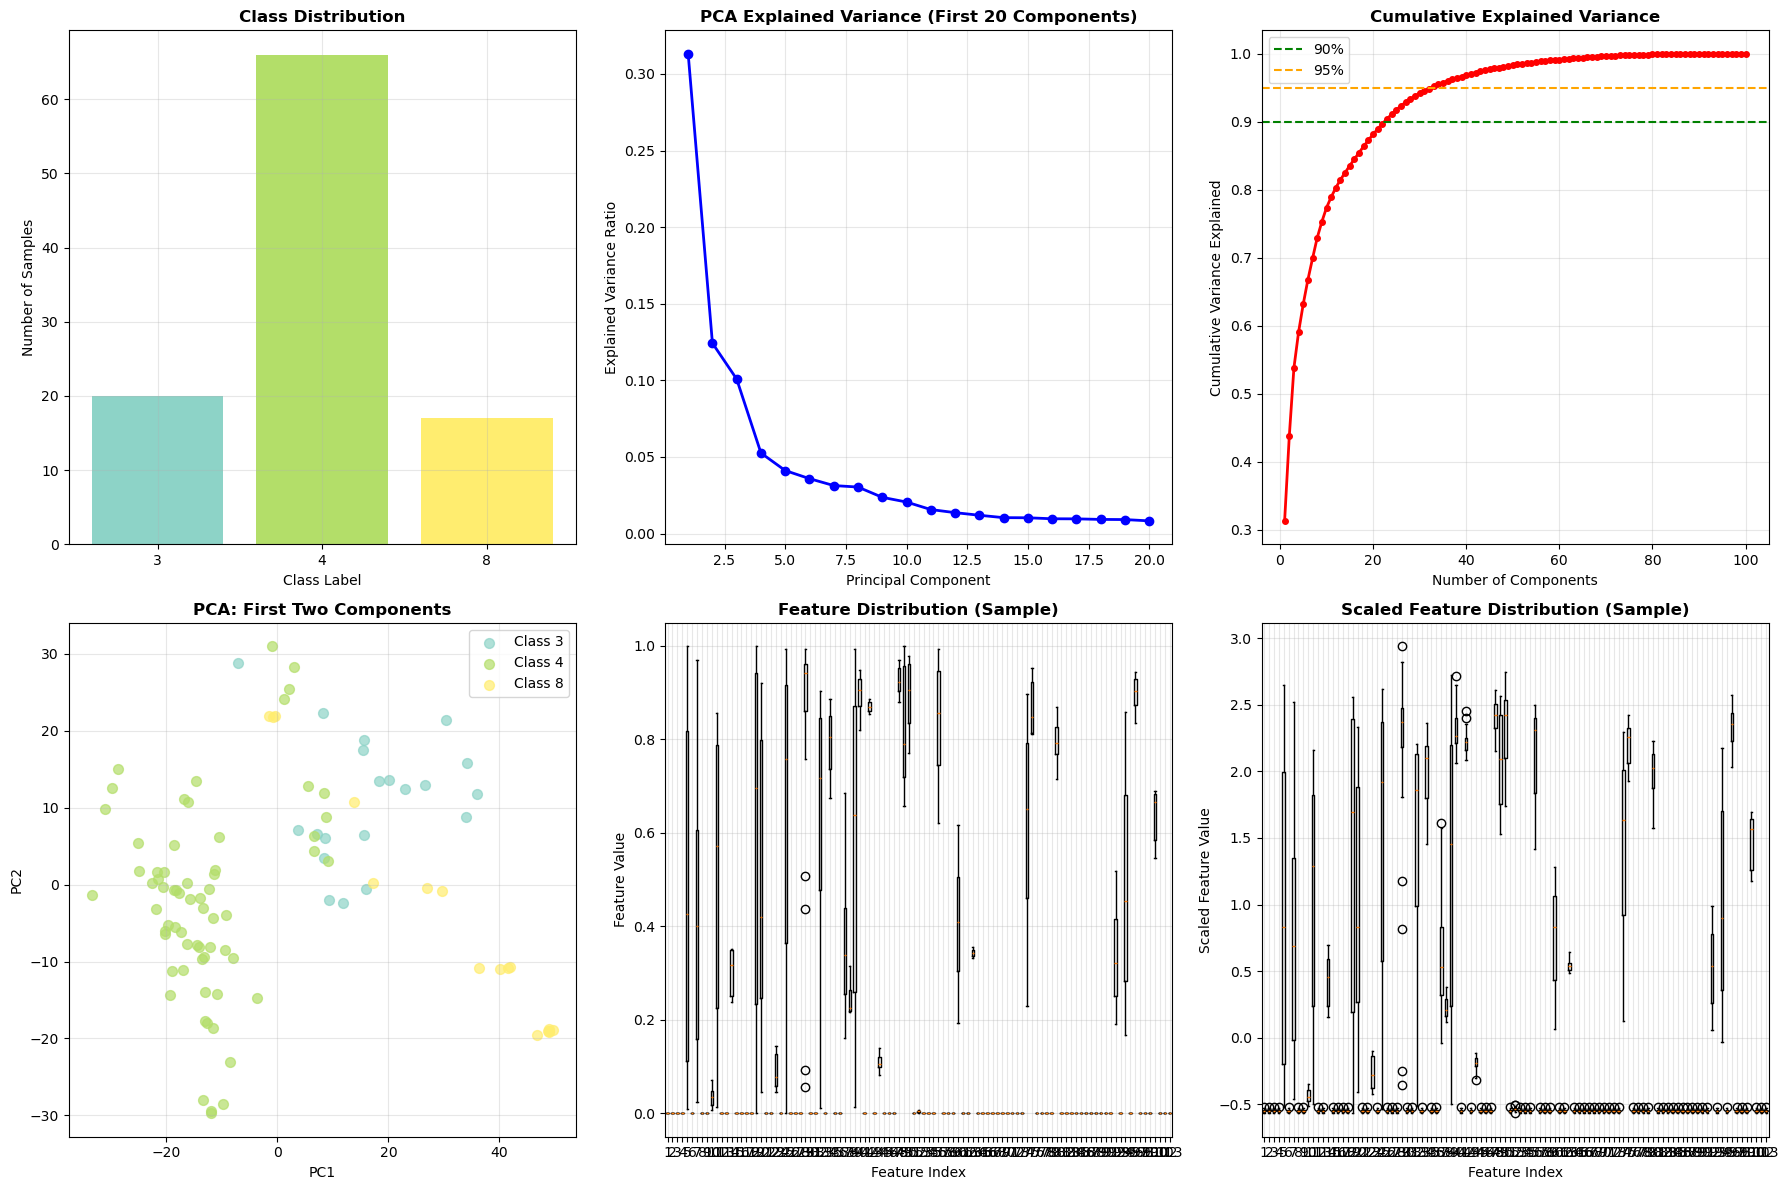

Data overview visualization complete!


In [5]:
# ============================================================
# DATA OVERVIEW VISUALIZATION
# ============================================================

if clustering_data is not None:
    
    print("Creating Data Overview Visualizations...")
    
    # Import visualization utilities
    from src.clustering_visualization import ClusteringVisualizer
    import matplotlib.pyplot as plt
    
    # Create visualizer
    visualizer = ClusteringVisualizer()
    
    # Create data overview plots
    visualizer.plot_data_overview(
        X_original=clustering_data['X_original'],
        X_scaled=clustering_data['X_scaled'],
        y_labels=clustering_data['y_labels'],
        pca_model=clustering_data['pca_model'],
        X_pca_2d=clustering_data['X_pca_2d']
    )
    
    print("Data overview visualization complete!")
    
else:
    print("No clustering data available for visualization")
    print("   Please run the previous cells first")

In [6]:
# ============================================================
# K-MEANS CLUSTERING: PARAMETER OPTIMIZATION
# ============================================================

if clustering_data is not None:
    print("K-means Clustering: Parameter Optimization")
    print("=" * 45)

    # Import K-means utilities
    from src.clustering_utils import KMeansAnalyzer
    
    # Extract preprocessed data
    X_scaled = clustering_data["X_scaled"]
    X_pca_50 = clustering_data["X_pca_50"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]

    print(f"K-means Analysis Setup:")
    print(f"   • Standardized data: {X_scaled.shape}")
    print(f"   • PCA reduced (50D): {X_pca_50.shape}")
    print(f"   • PCA visualization (2D): {X_pca_2d.shape}")
    print(f"   • True classes: {len(np.unique(y_true))} classes {list(np.unique(y_true))}")

    # Initialize K-means analyzer
    kmeans_analyzer = KMeansAnalyzer(k_range=range(2, 16))
    
    print("\nFinding optimal K using elbow method and silhouette analysis...")
    
    # Find optimal K
    results, optimal_k_scaled, optimal_k_pca = kmeans_analyzer.find_optimal_k(X_scaled, X_pca_50)
    
    # Get best model configuration
    best_model_info = kmeans_analyzer.get_best_model(results, optimal_k_scaled, optimal_k_pca, X_scaled, X_pca_50)
    
    print(f"\nOptimal K Selection Results:")
    print(f"   • Optimal K (Scaled data): {optimal_k_scaled}")
    print(f"   • Optimal K (PCA 50D): {optimal_k_pca}")
    print(f"   • Best configuration: {best_model_info['best_data_type']} with K={best_model_info['best_k']}")
    print(f"   • True number of classes: {len(np.unique(y_true))}")
    
    # Store results for next cells
    kmeans_optimization = {
        'results': results,
        'optimal_k_scaled': optimal_k_scaled,
        'optimal_k_pca': optimal_k_pca,
        'best_model_info': best_model_info
    }
    
    print("\nK-means parameter optimization complete!")

else:
    print("No clustering data available")
    print("   Please run the data preparation cells first")
    kmeans_optimization = None

K-means Clustering: Parameter Optimization
K-means Analysis Setup:
   • Standardized data: (103, 1500)
   • PCA reduced (50D): (103, 50)
   • PCA visualization (2D): (103, 2)
   • True classes: 3 classes [np.str_('3'), np.str_('4'), np.str_('8')]

Finding optimal K using elbow method and silhouette analysis...
K-means: Finding Optimal K
Testing K=2... OK
Testing K=3... OK
Testing K=4... OK
Testing K=5... OK
Testing K=3... OK
Testing K=4... OK
Testing K=5... OK
Testing K=6... OK
Testing K=7... OK
Testing K=6... OK
Testing K=7... OK
Testing K=8... OK
Testing K=9... OK
Testing K=8... OK
Testing K=9... OK
Testing K=10... OK
Testing K=11... OK
Testing K=10... OK
Testing K=11... OK
Testing K=12... OK
Testing K=13... OK
Testing K=12... OK
Testing K=13... OK
Testing K=14... OK
Testing K=15... OK
Testing K=14... OK
Testing K=15... OK

Optimal K Selection Results:
   • Optimal K (Scaled data): 3
   • Optimal K (PCA 50D): 4
   • Best configuration: PCA 50D with K=4
   • True number of classes: 3


In [7]:
# ============================================================
# K-MEANS CLUSTERING: FINAL RESULTS AND EVALUATION
# ============================================================

if "kmeans_optimization" in locals() and kmeans_optimization is not None:
    
    print("K-means Clustering: Final Results and Evaluation")
    print("=" * 50)
    
    # Import evaluation utilities
    from src.clustering_utils import ClusteringEvaluator
    from sklearn.metrics import silhouette_score, adjusted_rand_score
    
    # Extract optimization results
    best_model_info = kmeans_optimization['best_model_info']
    best_model = best_model_info['best_model']
    best_k = best_model_info['best_k']
    data_type = best_model_info['best_data_type']
    optimal_labels = best_model_info['optimal_labels']
    best_data = best_model_info['best_data']
    
    print(f"Applying optimal K-means clustering...")
    print(f"   • Method: {data_type}")
    print(f"   • Optimal K: {best_k}")
    
    # Calculate evaluation metrics
    evaluator = ClusteringEvaluator()
    metrics = evaluator.evaluate_clustering(y_true, optimal_labels, best_data)
    
    print(f"\nK-means Performance Evaluation:")
    print(f"   • Silhouette Score: {metrics['silhouette_score']:.3f}")
    print(f"   • Adjusted Rand Index: {metrics['adjusted_rand_index']:.3f}")
    print(f"   • WCSS: {best_model.inertia_:.2e}")

    # Cluster size analysis
    unique_clusters, cluster_counts = np.unique(optimal_labels, return_counts=True)
    print(f"\nCluster Size Distribution:")
    for cluster, count in zip(unique_clusters, cluster_counts):
        percentage = (count / len(optimal_labels)) * 100
        print(f"   • Cluster {cluster}: {count} samples ({percentage:.1f}%)")

    # Calculate centroids in 2D PCA space for visualization
    if data_type == "PCA 50D":
        # For PCA data, centroids are already in PCA space, just take first 2 components
        centroids_2d = best_model.cluster_centers_[:, :2]
    else:
        # Transform centroids from scaled space to 2D PCA
        centroids_2d = clustering_data['pca_model'].transform(best_model.cluster_centers_)[:, :2]

    # Store K-means results for next cells
    kmeans_results = {
        'best_model': best_model,
        'best_k': best_k,
        'best_data_type': data_type,
        'optimal_labels': optimal_labels,
        'silhouette_score': metrics['silhouette_score'],
        'ari_score': metrics['adjusted_rand_index'],
        'elbow_analysis': kmeans_optimization['results'],
        'centroids_2d': centroids_2d,
        'optimal_k_scaled': kmeans_optimization['optimal_k_scaled'],
        'optimal_k_pca': kmeans_optimization['optimal_k_pca']
    }

    print(f"\nK-means clustering analysis complete!")

else:
    print("K-means optimization results not available")
    print("   Please run the K-means parameter optimization cell first")
    kmeans_results = None

K-means Clustering: Final Results and Evaluation
Applying optimal K-means clustering...
   • Method: PCA 50D
   • Optimal K: 4

K-means Performance Evaluation:
   • Silhouette Score: 0.265
   • Adjusted Rand Index: 0.647
   • WCSS: 8.86e+04

Cluster Size Distribution:
   • Cluster 0: 13 samples (12.6%)
   • Cluster 1: 56 samples (54.4%)
   • Cluster 2: 6 samples (5.8%)
   • Cluster 3: 28 samples (27.2%)

K-means clustering analysis complete!


Creating K-means Analysis Visualizations...


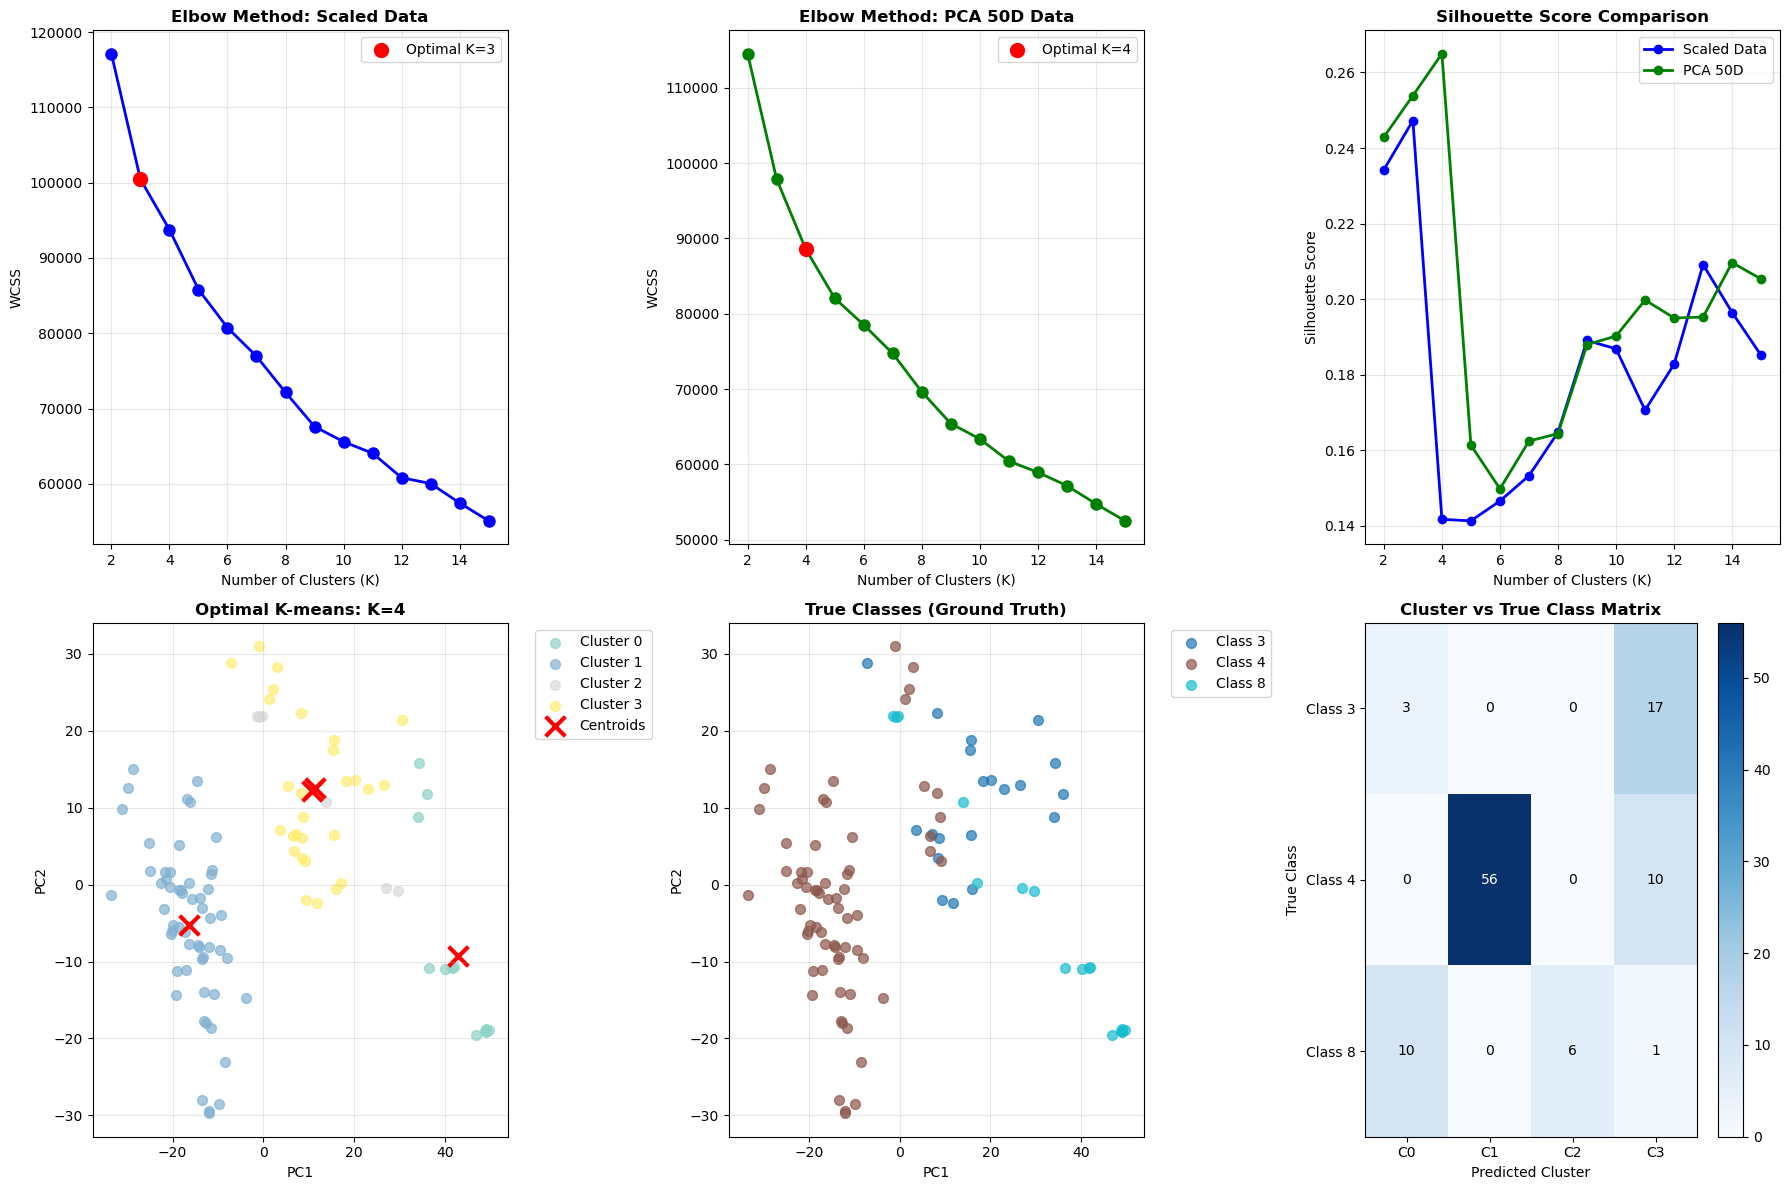

K-means visualization complete!


In [8]:
# ============================================================
# K-MEANS VISUALIZATION
# ============================================================

if "kmeans_results" in locals() and kmeans_results is not None:
    
    print("Creating K-means Analysis Visualizations...")
    
    # Create K-means analysis plots
    visualizer.plot_kmeans_analysis(
        k_range=range(2, 16),
        results=kmeans_results['elbow_analysis'],
        optimal_k_scaled=kmeans_results['optimal_k_scaled'],
        optimal_k_pca=kmeans_results['optimal_k_pca'],
        X_pca_2d=clustering_data['X_pca_2d'],
        optimal_labels=kmeans_results['optimal_labels'],
        centroids_2d=kmeans_results['centroids_2d'],
        y_true=clustering_data['y_labels'],
        n_clusters=kmeans_results['best_k']
    )
    
    print("K-means visualization complete!")
    
else:
    print("K-means results not available for visualization")
    print("   Please run the K-means clustering cells first")

In [9]:
# ============================================================
# MEAN SHIFT CLUSTERING
# ============================================================

if clustering_data is not None and "kmeans_results" in locals():
    print("Mean Shift Clustering Analysis")
    print("=" * 35)

    # Import advanced clustering utilities
    from src.clustering_utils import AdvancedClusteringAnalyzer
    
    # Extract data for clustering
    X_normalized = clustering_data["X_normalized"]
    X_pca_50 = clustering_data["X_pca_50"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]

    print(f"Mean Shift Setup:")
    print(f"   • Normalized data: {X_normalized.shape}")
    print(f"   • PCA 50D data: {X_pca_50.shape}")
    print(f"   • True classes: {len(np.unique(y_true))}")

    # Initialize advanced clustering analyzer
    advanced_analyzer = AdvancedClusteringAnalyzer()
    
    # Run Mean Shift clustering
    meanshift_results = advanced_analyzer.run_mean_shift(X_pca_50, X_normalized)
    
    print(f"\nMean Shift Results:")
    print(f"   • PCA data: {meanshift_results['pca']['n_clusters']} clusters found")
    print(f"   • Normalized data: {meanshift_results['normalized']['n_clusters']} clusters found (subset)")
    print(f"   • True classes: {len(np.unique(y_true))}")

    print("\nMean Shift clustering complete!")

else:
    print("No clustering data available or K-means results missing")
    print("   Please run the previous cells first")
    meanshift_results = None

Mean Shift Clustering Analysis
Mean Shift Setup:
   • Normalized data: (103, 1500)
   • PCA 50D data: (103, 50)
   • True classes: 3
Mean Shift Clustering

Mean Shift Results:
   • PCA data: 7 clusters found
   • Normalized data: 1 clusters found (subset)
   • True classes: 3

Mean Shift clustering complete!

Mean Shift Results:
   • PCA data: 7 clusters found
   • Normalized data: 1 clusters found (subset)
   • True classes: 3

Mean Shift clustering complete!


In [10]:
# ============================================================
# DBSCAN CLUSTERING
# ============================================================

if "meanshift_results" in locals() and meanshift_results is not None:
    
    print("DBSCAN Clustering Analysis")
    print("=" * 30)
    
    # Run DBSCAN clustering with parameter optimization
    dbscan_results = advanced_analyzer.run_dbscan(X_pca_50)
    
    if dbscan_results is not None:
        print(f"\nDBSCAN Results:")
        print(f"   • Best eps: {dbscan_results['params']['eps']:.4f}")
        print(f"   • Best min_samples: {dbscan_results['params']['min_samples']}")
        print(f"   • Clusters found: {dbscan_results['n_clusters']}")
        print(f"   • Noise points: {dbscan_results['n_noise']}")
        print(f"   • Silhouette score: {dbscan_results['silhouette']:.3f}")
    else:
        print(f"\nDBSCAN: No suitable parameters found")
        
    print("\nDBSCAN clustering complete!")

else:
    print("Mean Shift results not available")
    print("   Please run the Mean Shift clustering cell first")
    dbscan_results = None

DBSCAN Clustering Analysis
DBSCAN Clustering

DBSCAN Results:
   • Best eps: 22.4383
   • Best min_samples: 3
   • Clusters found: 6
   • Noise points: 76
   • Silhouette score: 0.001

DBSCAN clustering complete!


In [11]:
# ============================================================
# ADVANCED CLUSTERING EVALUATION
# ============================================================

if "dbscan_results" in locals():
    
    print("Advanced Clustering Evaluation")
    print("=" * 35)
    
    # Calculate performance metrics for all methods
    from sklearn.metrics import silhouette_score, adjusted_rand_score
    
    # Extract labels from each method
    kmeans_labels = kmeans_results['optimal_labels']
    ms_labels = meanshift_results['pca']['labels']
    
    # Calculate metrics
    methods = ["K-means", "Mean Shift", "DBSCAN"]
    
    # K-means metrics (already calculated)
    kmeans_silhouette = kmeans_results['silhouette_score']
    kmeans_ari = kmeans_results['ari_score']
    
    # Convert labels to consistent numeric format for ARI calculation
    y_true_numeric = np.array([int(str(label)) for label in y_true])
    
    # Mean Shift metrics
    ms_silhouette = silhouette_score(X_pca_50, ms_labels) if meanshift_results['pca']['n_clusters'] > 1 else 0
    ms_ari = adjusted_rand_score(y_true_numeric, ms_labels)
    
    # DBSCAN metrics
    if dbscan_results is not None:
        db_silhouette = dbscan_results['silhouette']
        db_ari = adjusted_rand_score(y_true_numeric, dbscan_results['labels'])
        n_clusters_found = [kmeans_results['best_k'], meanshift_results['pca']['n_clusters'], dbscan_results['n_clusters']]
    else:
        db_silhouette = 0
        db_ari = 0
        n_clusters_found = [kmeans_results['best_k'], meanshift_results['pca']['n_clusters'], 0]
    
    silhouette_scores = [kmeans_silhouette, ms_silhouette, db_silhouette]
    ari_scores = [kmeans_ari, ms_ari, db_ari]
    
    print(f"\nPerformance Comparison:")
    for i, method in enumerate(methods):
        print(f"   • {method}:")
        print(f"     - Clusters: {n_clusters_found[i]}")
        print(f"     - Silhouette: {silhouette_scores[i]:.3f}")
        print(f"     - ARI: {ari_scores[i]:.3f}")
    
    # Store advanced clustering results
    advanced_clustering_results = {
        'meanshift': meanshift_results,
        'dbscan': dbscan_results,
        'performance_comparison': {
            'methods': methods,
            'n_clusters': n_clusters_found,
            'silhouette_scores': silhouette_scores,
            'ari_scores': ari_scores
        }
    }
    
    print("\nAdvanced clustering evaluation complete!")

else:
    print("Advanced clustering results not available")
    print("   Please run the previous clustering cells first")
    advanced_clustering_results = None

Advanced Clustering Evaluation

Performance Comparison:
   • K-means:
     - Clusters: 4
     - Silhouette: 0.265
     - ARI: 0.647
   • Mean Shift:
     - Clusters: 7
     - Silhouette: 0.160
     - ARI: 0.626
   • DBSCAN:
     - Clusters: 6
     - Silhouette: 0.001
     - ARI: 0.125

Advanced clustering evaluation complete!


Creating Clustering Methods Comparison Visualization...


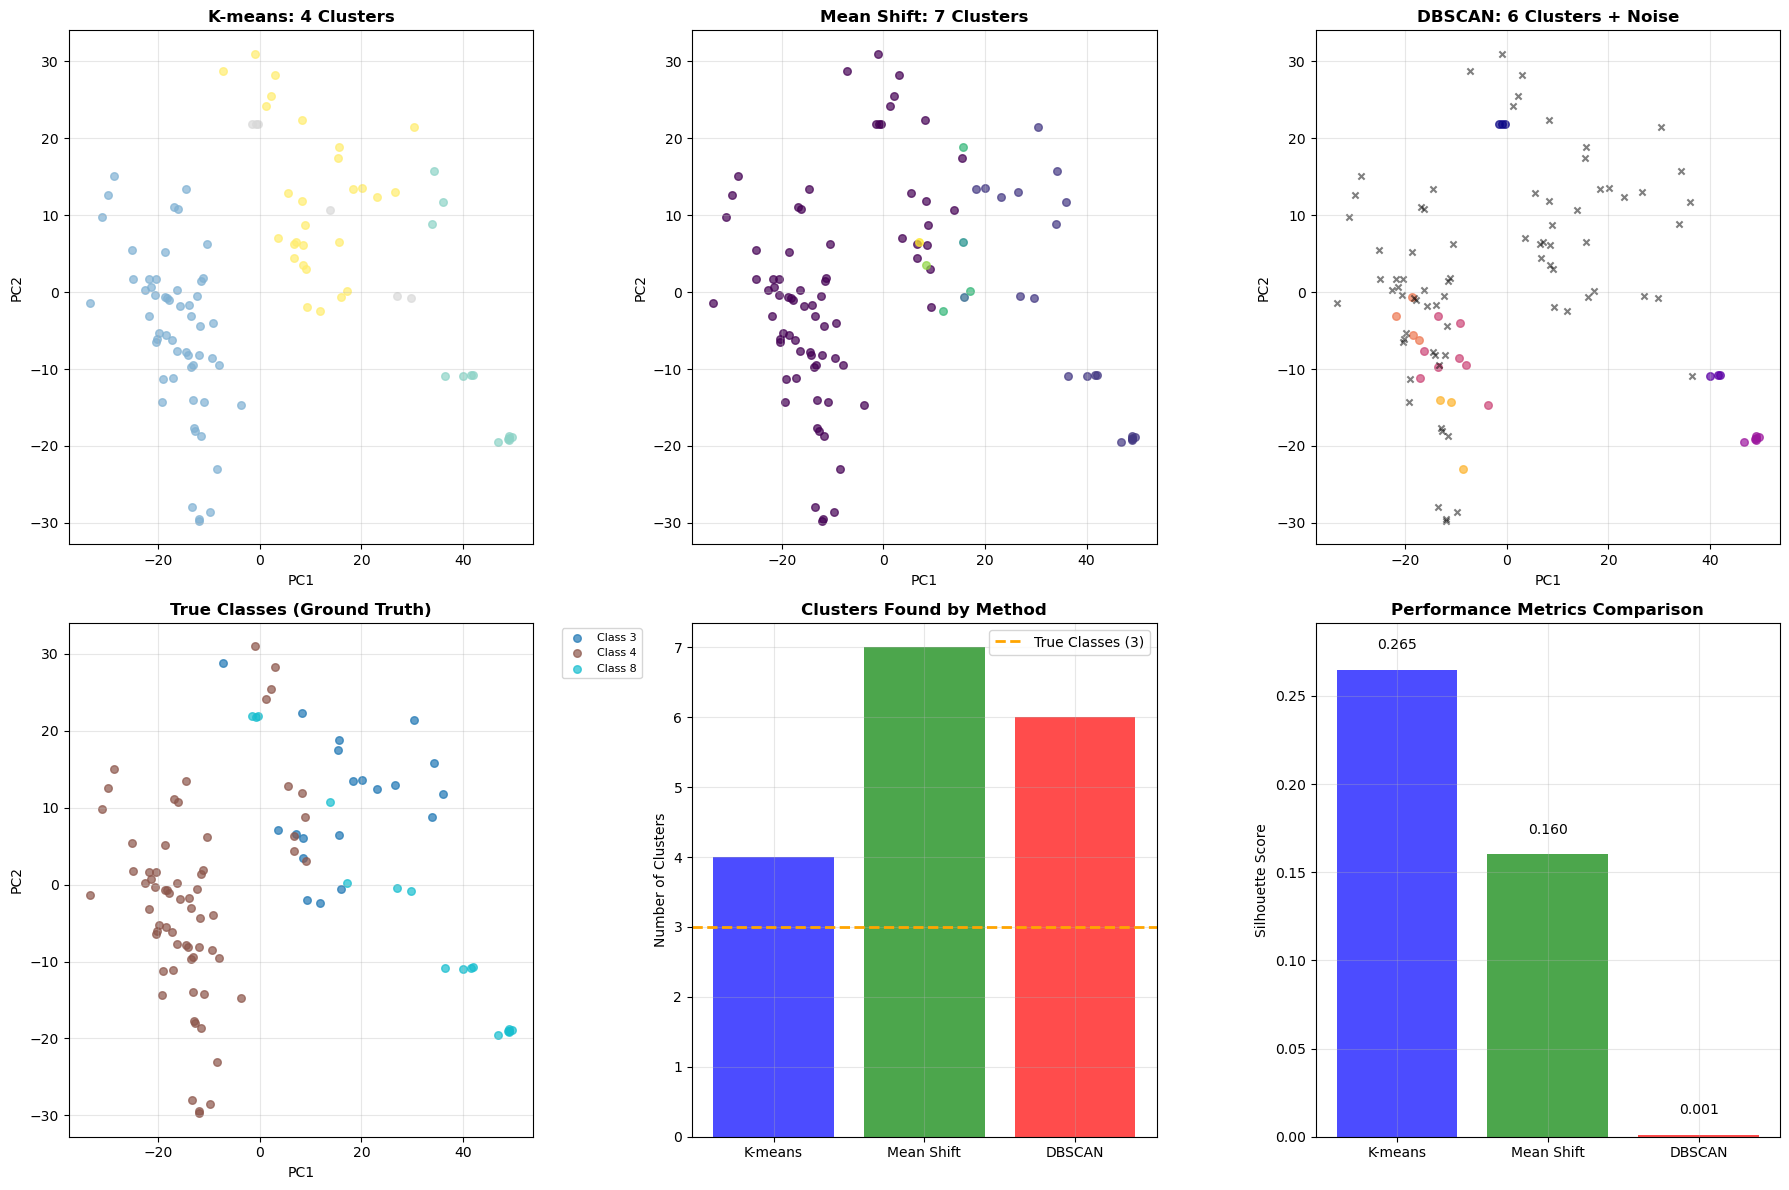

Clustering comparison visualization complete!


In [12]:
# ============================================================
# CLUSTERING METHODS COMPARISON VISUALIZATION
# ============================================================

if "advanced_clustering_results" in locals() and advanced_clustering_results is not None:
    
    print("Creating Clustering Methods Comparison Visualization...")
    
    # Create clustering comparison plots
    visualizer.plot_clustering_comparison(
        X_pca_2d=clustering_data['X_pca_2d'],
        kmeans_labels=kmeans_results['optimal_labels'],
        ms_labels=meanshift_results['pca']['labels'],
        dbscan_results=dbscan_results,
        y_true=clustering_data['y_labels'],
        methods=advanced_clustering_results['performance_comparison']['methods'],
        n_clusters_found=advanced_clustering_results['performance_comparison']['n_clusters'],
        silhouette_scores=advanced_clustering_results['performance_comparison']['silhouette_scores']
    )
    
    print("Clustering comparison visualization complete!")

else:
    print("Advanced clustering results not available for visualization")
    print("   Please run the previous clustering analysis cells first")

In [13]:
# ============================================================
# CLUSTER INTERPRETATION ANALYSIS
# ============================================================

if (
    "clustering_data" in locals()
    and clustering_data is not None
    and "kmeans_results" in locals()
    and kmeans_results is not None
    and "advanced_clustering_results" in locals()
    and advanced_clustering_results is not None
):

    print("Cluster Interpretation and Oil Well Operation Analysis")
    print("=" * 60)

    # Import analysis utilities
    import pandas as pd
    from scipy import stats

    # Extract data and results
    X_original = clustering_data["X_original"]
    X_pca_2d = clustering_data["X_pca_2d"]
    y_true = clustering_data["y_labels"]
    kmeans_labels = kmeans_results["optimal_labels"]
    n_clusters = kmeans_results["best_k"]

    print(f"Analysis Setup:")
    print(f"   • Total samples: {len(X_original)}")
    print(f"   • True oil well classes: {sorted(np.unique(y_true))}")
    print(f"   • K-means clusters: {n_clusters}")
    print(f"   • Feature dimensions: {X_original.shape[1]}")

    # Use evaluator to interpret clusters
    result = evaluator.interpret_clusters(y_true, kmeans_labels, X_original)
    if len(result) == 4:
        cluster_interpretations, cluster_class_matrix, unique_true_classes, unique_clusters = result
    else:
        # Backwards compatibility
        cluster_interpretations, cluster_class_matrix = result
        unique_true_classes = sorted(np.unique([int(str(label)) for label in y_true]))
        unique_clusters = sorted(np.unique(kmeans_labels))
    
    print(f"\nCluster-Class Correspondence Analysis:")
    cluster_class_df = pd.DataFrame(
        cluster_class_matrix,
        index=[f"True Class {i}" for i in unique_true_classes],
        columns=[f"Cluster {i}" for i in unique_clusters],
    )
    print(cluster_class_df.to_string())

    # Calculate clustering accuracy using the Hungarian algorithm for optimal assignment
    from scipy.optimize import linear_sum_assignment
    
    # Find optimal cluster-to-class assignment
    cost_matrix = -cluster_class_matrix  # Negative because we want to maximize matches
    row_indices, col_indices = linear_sum_assignment(cost_matrix)
    
    # Calculate accuracy based on optimal assignment
    optimal_matches = cluster_class_matrix[row_indices, col_indices].sum()
    total_samples = cluster_class_matrix.sum()
    clustering_accuracy = optimal_matches / total_samples
    
    print(f"\nClustering Performance Metrics:")
    print(f"   • Optimal Cluster-Class Assignment Accuracy: {clustering_accuracy:.3f} ({clustering_accuracy*100:.1f}%)")
    print(f"   • Optimal Assignment Mapping:")
    for true_class_idx, cluster_idx in zip(row_indices, col_indices):
        true_class = unique_true_classes[true_class_idx]
        cluster = unique_clusters[cluster_idx]
        matches = cluster_class_matrix[true_class_idx, cluster_idx]
        print(f"     - Class {true_class} → Cluster {cluster}: {matches} samples")

    # Display cluster interpretations
    print(f"\nCluster Interpretations:")
    for cluster_id, interpretation in cluster_interpretations.items():
        print(f"   • Cluster {cluster_id}: {interpretation['size']} samples ({interpretation['size']/len(kmeans_labels)*100:.1f}%)")
        print(f"     - Dominant: Class {interpretation['dominant_class']} ({interpretation['dominant_percentage']:.1f}%)")
        print(f"     - Operation: {interpretation['operation_type']}")
        print(f"     - Description: {interpretation['description']}")

    print("\nCluster interpretation analysis complete!")

else:
    print("Missing required data or results")
    print("   Please run all previous clustering cells first")
    cluster_interpretations = None
    cluster_class_matrix = None

Cluster Interpretation and Oil Well Operation Analysis
Analysis Setup:
   • Total samples: 103
   • True oil well classes: [np.str_('3'), np.str_('4'), np.str_('8')]
   • K-means clusters: 4
   • Feature dimensions: 1500

Cluster-Class Correspondence Analysis:
              Cluster 0  Cluster 1  Cluster 2  Cluster 3
True Class 3          3          0          0         17
True Class 4          0         56          0         10
True Class 8         10          0          6          1

Clustering Performance Metrics:
   • Optimal Cluster-Class Assignment Accuracy: 0.806 (80.6%)
   • Optimal Assignment Mapping:
     - Class 3 → Cluster 3: 17 samples
     - Class 4 → Cluster 1: 56 samples
     - Class 8 → Cluster 0: 10 samples

Cluster Interpretations:
   • Cluster 0: 13 samples (12.6%)
     - Dominant: Class 8 (76.9%)
     - Operation: Severe Faults
     - Description: Critical operational issues requiring immediate attention
   • Cluster 1: 56 samples (54.4%)
     - Dominant: Class 4 (1

Creating Cluster Interpretation Visualization...


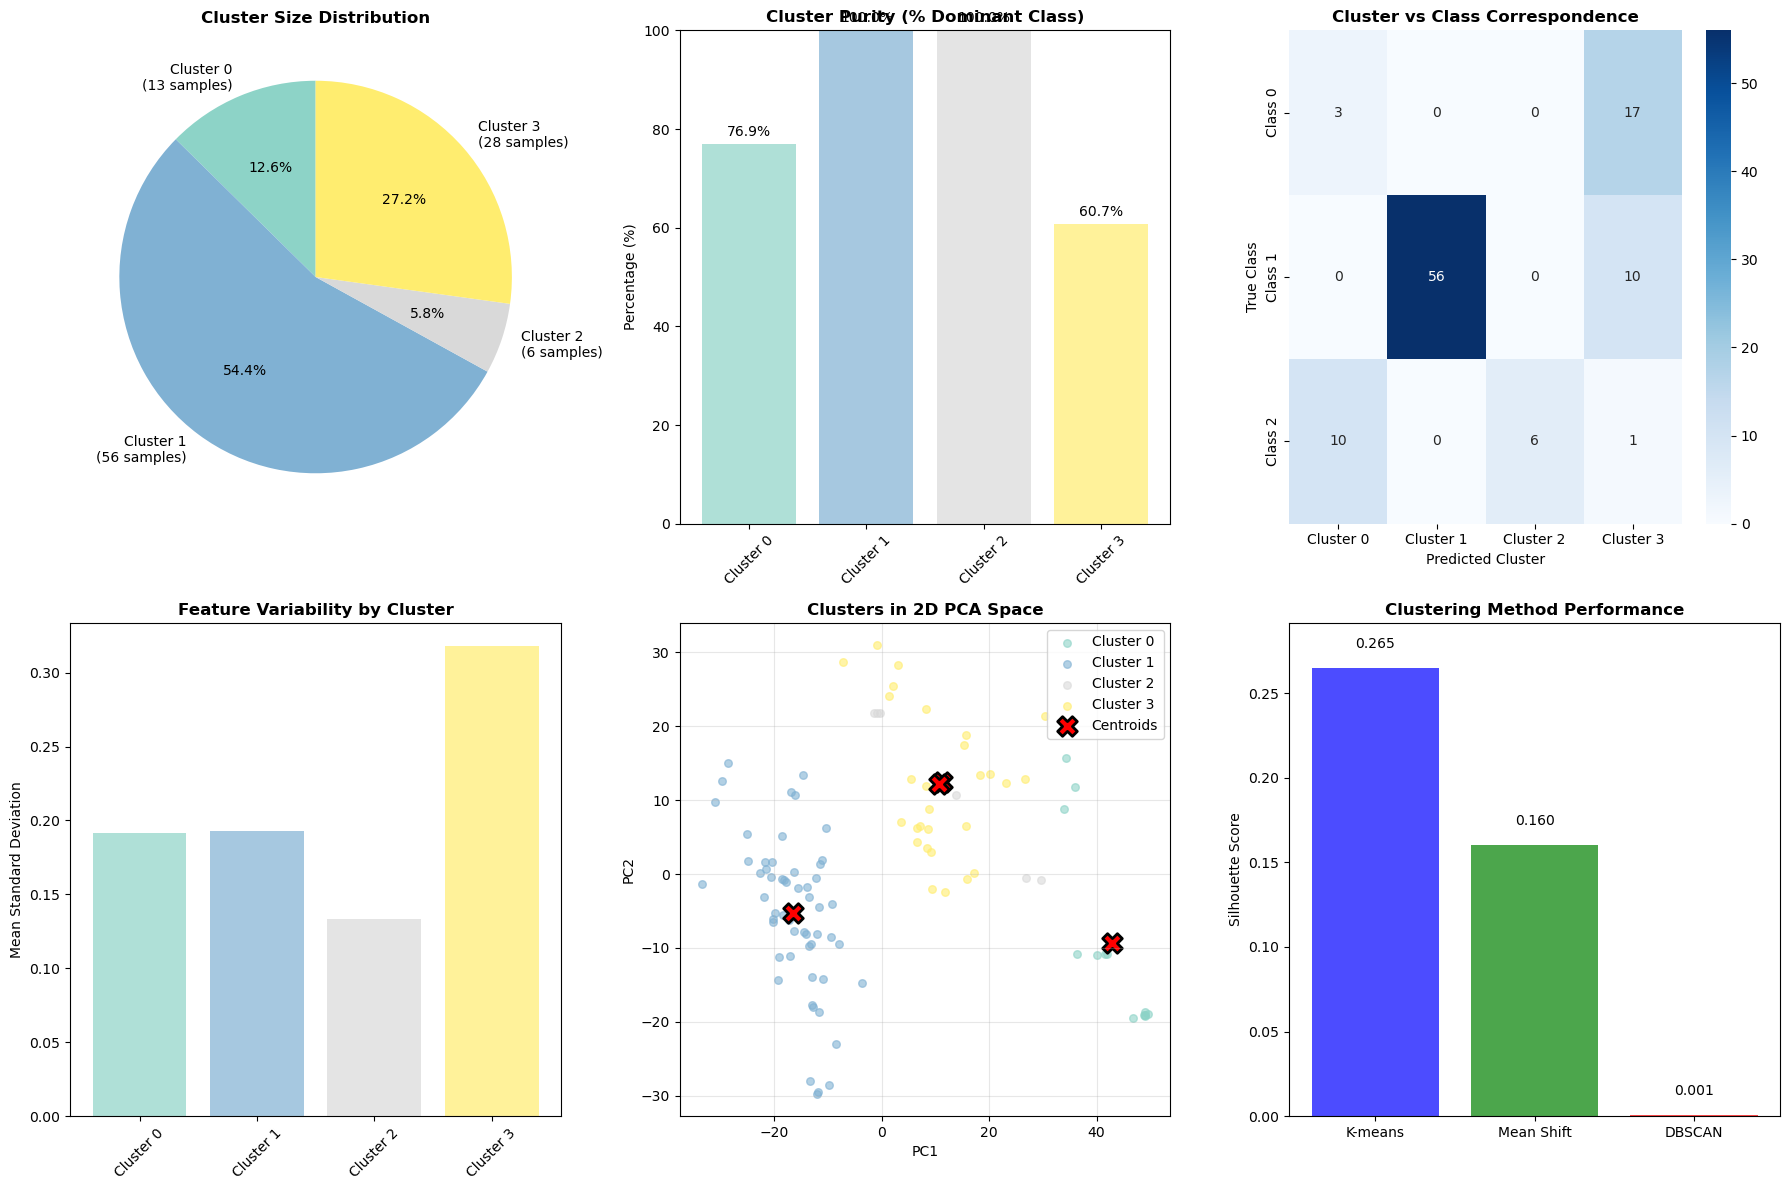

Cluster interpretation visualization complete!


In [14]:
# ============================================================
# CLUSTER INTERPRETATION VISUALIZATION
# ============================================================

if "cluster_interpretations" in locals() and cluster_interpretations is not None:
    
    print("Creating Cluster Interpretation Visualization...")
    
    # Prepare feature statistics for visualization
    cluster_feature_stats = {}
    for cluster_id, interpretation in cluster_interpretations.items():
        cluster_feature_stats[cluster_id] = interpretation['feature_stats']
    
    # Create cluster interpretation plots
    visualizer.plot_cluster_interpretation(
        cluster_interpretations=cluster_interpretations,
        cluster_class_matrix=cluster_class_matrix,
        cluster_feature_stats=cluster_feature_stats,
        X_pca_2d=clustering_data['X_pca_2d'],
        kmeans_labels=kmeans_results['optimal_labels'],
        centroids_2d=kmeans_results['centroids_2d'],
        silhouette_scores=advanced_clustering_results['performance_comparison']['silhouette_scores'],
        methods=advanced_clustering_results['performance_comparison']['methods']
    )
    
    print("Cluster interpretation visualization complete!")

else:
    print("Cluster interpretation data not available")
    print("   Please run the cluster interpretation analysis cell first")

In [15]:
# ============================================================
# FINAL ANALYSIS SUMMARY
# ============================================================

if "cluster_interpretations" in locals() and cluster_interpretations is not None:
    
    print("Final Clustering Analysis Summary")
    print("=" * 40)

    # Calculate summary statistics
    methods = advanced_clustering_results['performance_comparison']['methods']
    silhouette_scores = advanced_clustering_results['performance_comparison']['silhouette_scores']
    
    best_method = methods[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    
    # Calculate average cluster purity
    cluster_purities = [cluster_interpretations[i]['dominant_percentage'] for i in range(n_clusters)]
    avg_purity = np.mean(cluster_purities)

    print(f"\nClustering Performance Summary:")
    print(f"   • Best performing method: {best_method} (Silhouette: {best_score:.3f})")
    print(f"   • Average cluster purity: {avg_purity:.1f}%")
    print(f"   • Number of clusters found: {n_clusters}")
    print(f"   • True classes in dataset: {len(np.unique(y_true))}")

    print(f"\nPattern Discovery Results:")
    if avg_purity > 70:
        print(f"   High cluster purity ({avg_purity:.1f}%) - clusters align well with true classes")
    elif avg_purity > 50:
        print(f"   Moderate cluster purity ({avg_purity:.1f}%) - some mixing between classes")
    else:
        print(f"   Low cluster purity ({avg_purity:.1f}%) - significant class mixing")

    # Identify most distinct operational patterns
    most_pure_cluster = np.argmax(cluster_purities)
    most_distinct_class = cluster_interpretations[most_pure_cluster]['dominant_class']

    print(f"\nOperational Pattern Analysis:")
    print(f"   • Most distinct pattern: Cluster {most_pure_cluster}")
    print(f"     - Represents Class {most_distinct_class} operations")
    print(f"     - Purity: {cluster_purities[most_pure_cluster]:.1f}%")
    print(f"     - Size: {cluster_interpretations[most_pure_cluster]['size']} samples")
    print(f"     - Operation: {cluster_interpretations[most_pure_cluster]['operation_type']}")

    if n_clusters > len(np.unique(y_true)):
        print(f"   • {n_clusters} clusters > {len(np.unique(y_true))} classes suggests sub-patterns within operations")
    elif n_clusters < len(np.unique(y_true)):
        print(f"   • {n_clusters} clusters < {len(np.unique(y_true))} classes suggests some operations are similar")

    # Store final comprehensive results
    clustering_insights = {
        'cluster_interpretations': cluster_interpretations,
        'performance_summary': {
            'best_method': best_method,
            'best_silhouette': best_score,
            'average_purity': avg_purity,
            'most_distinct_cluster': most_pure_cluster,
        },
        'analysis_complete': True
    }

    print(f"\nComplete Clustering Analysis Finished!")
    print(f"Results stored in 'clustering_insights' for further analysis.")

else:
    print("Cannot generate final summary - cluster interpretations not available")
    clustering_insights = None

Final Clustering Analysis Summary

Clustering Performance Summary:
   • Best performing method: K-means (Silhouette: 0.265)
   • Average cluster purity: 84.4%
   • Number of clusters found: 4
   • True classes in dataset: 3

Pattern Discovery Results:
   High cluster purity (84.4%) - clusters align well with true classes

Operational Pattern Analysis:
   • Most distinct pattern: Cluster 1
     - Represents Class 4 operations
     - Purity: 100.0%
     - Size: 56 samples
     - Operation: Pressure-related Issues
   • 4 clusters > 3 classes suggests sub-patterns within operations

Complete Clustering Analysis Finished!
Results stored in 'clustering_insights' for further analysis.
